In [2]:
from pathlib import Path
from tqdm import tqdm
from typing import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


ROOT_DIR = Path(os.getcwd()).parent

In [3]:
df = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_25_04.parquet")
)

df = df.reset_index(drop=True)
df["pump_hash"] = df["pumped_ticker"] + df["pump_time"]
df.shape

(725, 214)

In [4]:
df.isna().sum().sort_values(ascending=False).head(35)

quote_slippage_imbalance_ratio_1h               10782
quote_abs_long_ratio_1h_1d                      10656
imbalance_ratio_1h                              10656
long_trades_ratio_1h                            10656
quote_slippage_quote_abs_ratio_1h               10656
quote_slippage_imbalance_ratio_1h_std_14d        3547
quote_slippage_imbalance_ratio_1h_std_7d         2263
quote_slippage_imbalance_ratio_1h_std_5d         1745
quote_slippage_imbalance_ratio_2h                1099
quote_slippage_imbalance_ratio_1h_mean_14d        980
quote_slippage_imbalance_ratio_1h_std_2d          821
quote_slippage_imbalance_ratio_1h_std_1d          475
quote_slippage_imbalance_ratio_1h_mean_7d         357
quote_slippage_imbalance_ratio_5h                 252
quote_slippage_imbalance_ratio_1h_mean_5d         215
quote_slippage_imbalance_ratio_7h                 150
daily_exchange_volume_share_30d_std                83
daily_exchange_volume_share_3d_std                 77
daily_exchange_volume_share_

In [5]:
daily_exchange_cols: List[str] = [
    'daily_exchange_volume_share_30d_std',
    'daily_exchange_volume_share_3d_std',
    'daily_exchange_volume_share_14d_std',
    'daily_exchange_volume_share_7d_std'
]

df_features = pd.DataFrame()

for (pumped_ticker, pump_time), df_pump in df.groupby(["pumped_ticker", "pump_time"]):
    if df_pump[df_pump["ticker"] == pumped_ticker][daily_exchange_cols].isna().any().any():
        continue

    for col in daily_exchange_cols:
        df_pump[col] = df_pump[col].fillna(df_pump[col].median())
    df_features = pd.concat([df_features, df_pump])

In [6]:
df_features = df_features.fillna(0)

In [7]:
num_cols: List[str] = df.columns[:-7]

In [8]:
df_pumps: pd.DataFrame = pd.DataFrame()

for i, (pump_hash, df_pump) in enumerate(df_features.groupby("pump_hash")):
    if i > 3:
        continue
    df_pumps = pd.concat([df_pump, df_pumps])

 40%|████      | 20/50 [00:00<00:01, 21.79it/s]


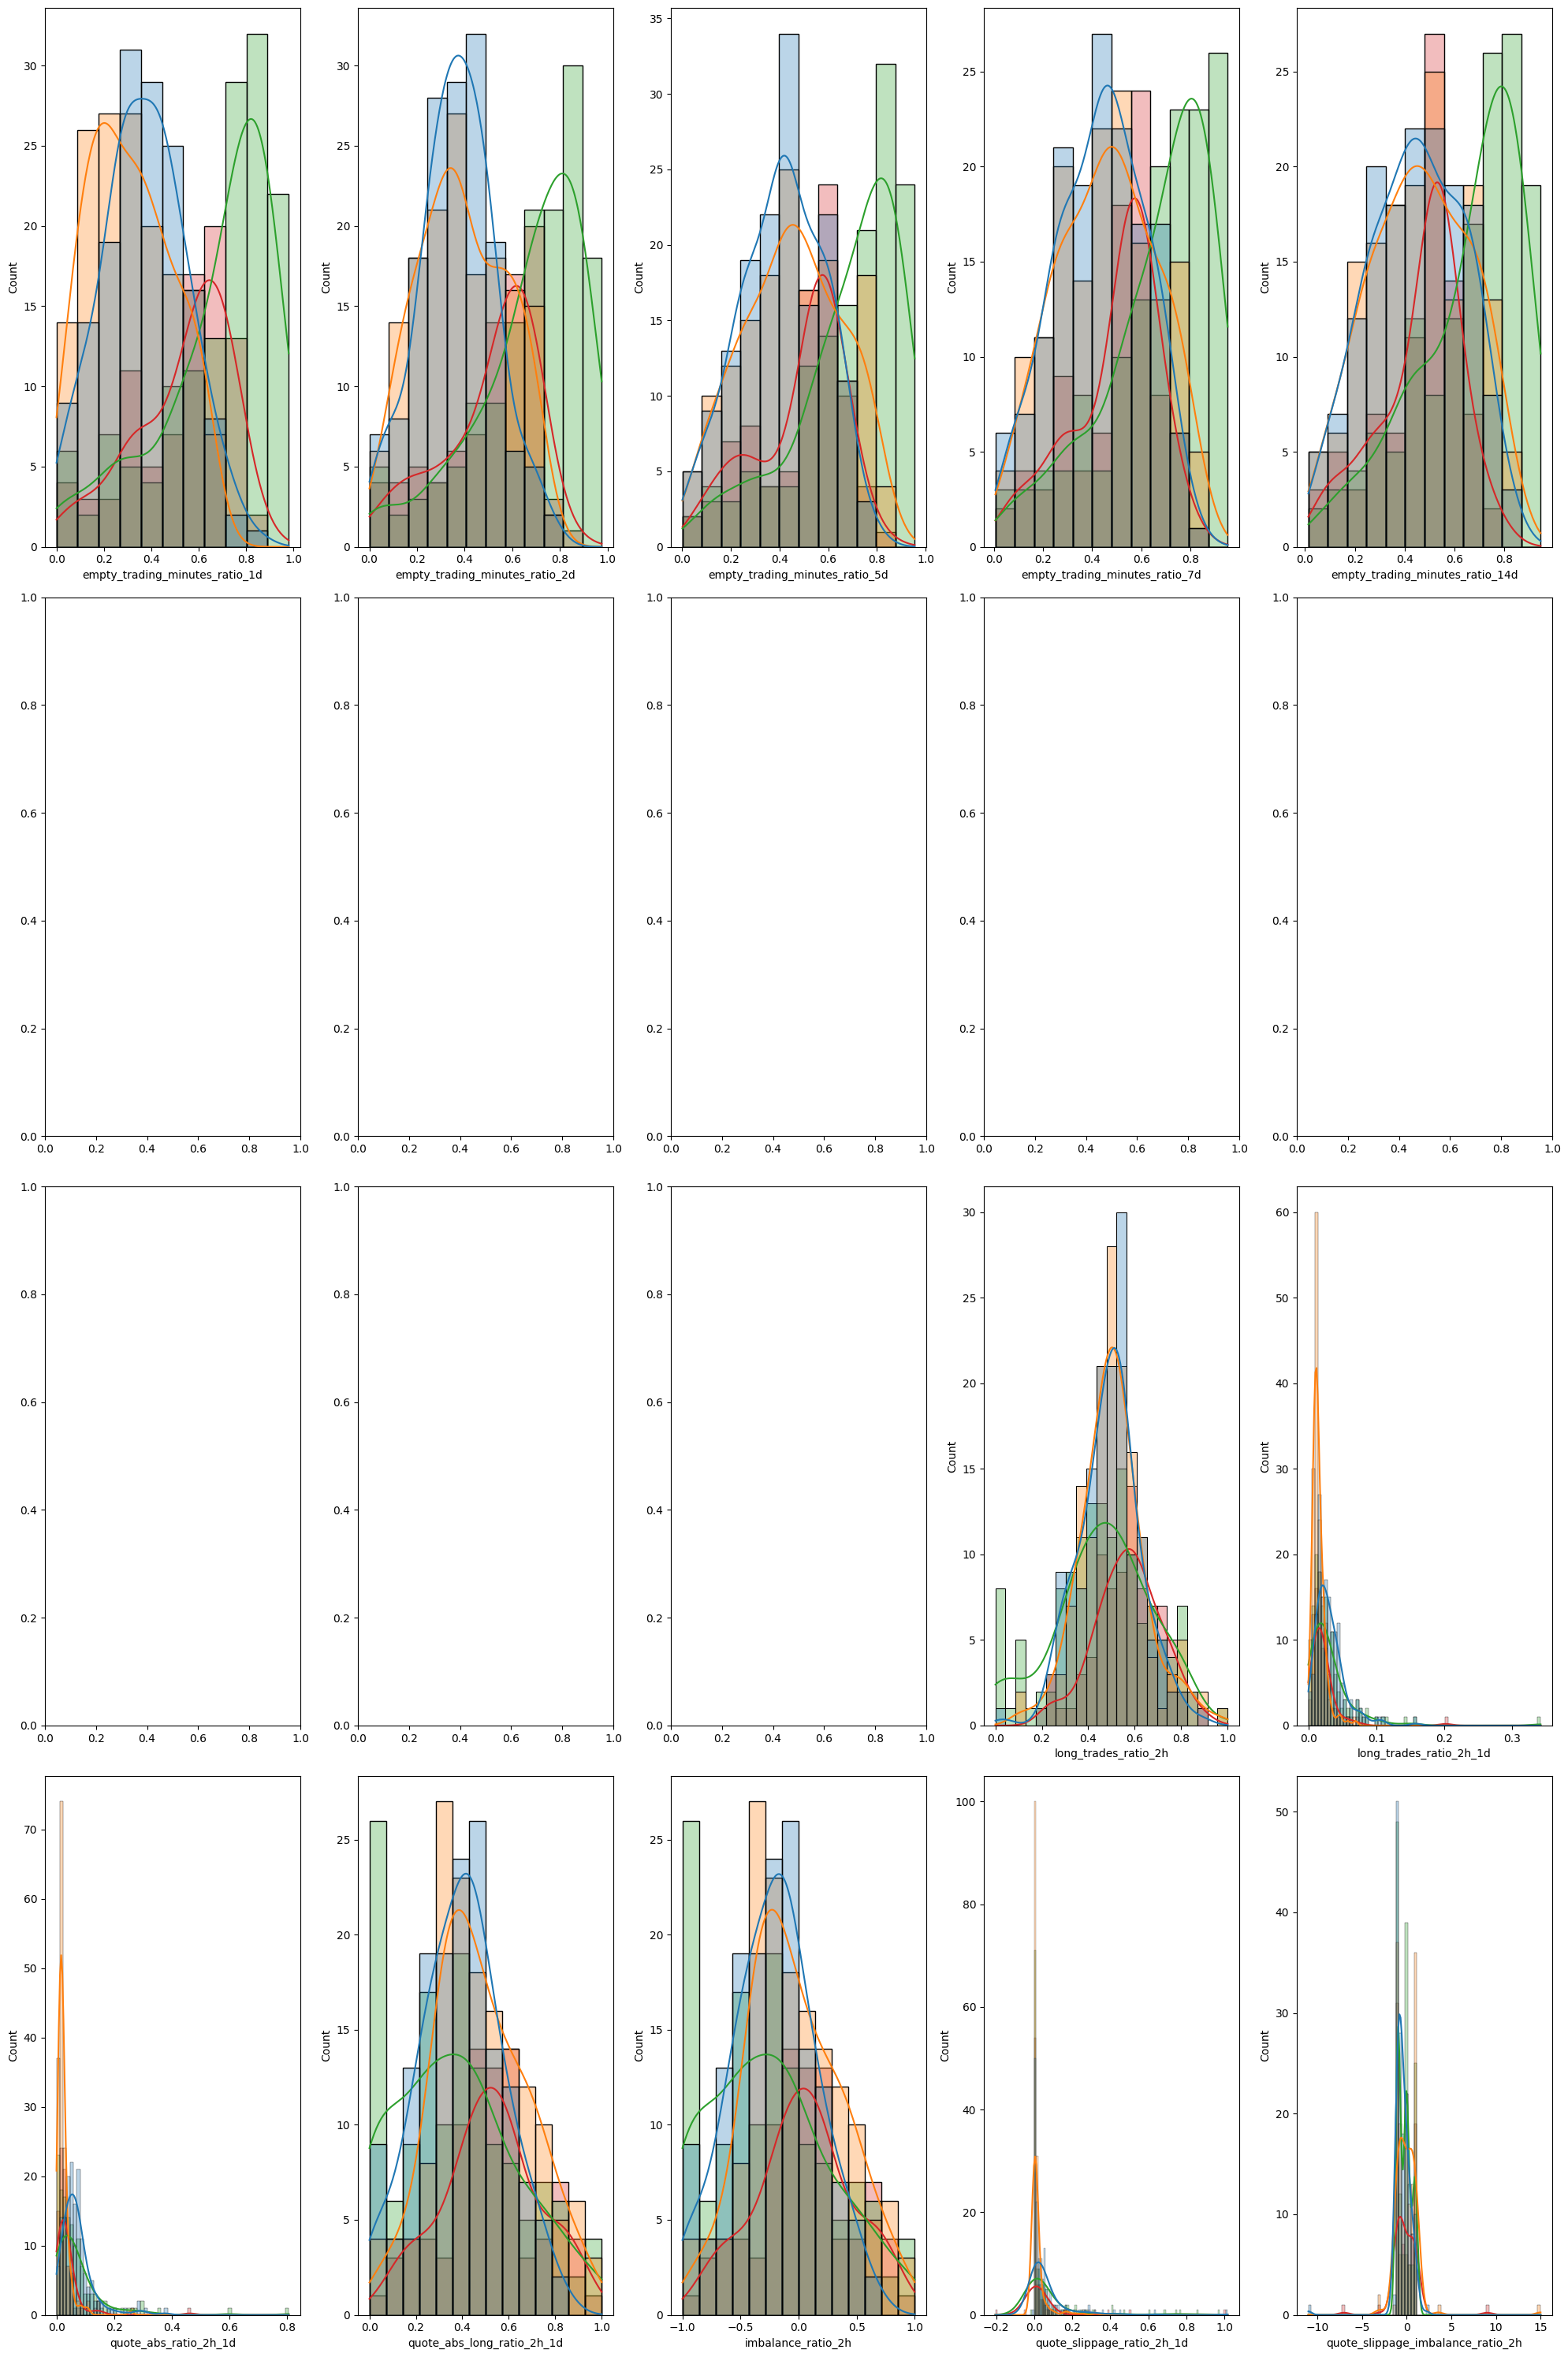

In [9]:
fig, axs = plt.subplots(4, 5, figsize=(20, 30))
axs = [ax for ax_list in axs for ax in ax_list]

for col, ax in tqdm(zip(num_cols[150:], axs), total=50):
    try:
        sns.histplot(data=df_pumps, x=col, hue="pump_hash", kde=True, alpha=.3, ax=ax, legend=False)
    except:
        pass

plt.tight_layout()
plt.show()

<h4>Apply crosssectional normalization</h4>

In [10]:
num_cols: List[str] = df.columns[:-7]

n_cols: int = len(num_cols)
n_cols

204

In [11]:
# fig, axs = plt.subplots(n_cols // 4, 4, figsize=(60, 40))
# axs = [el for ax in axs for el in ax]

# for ax, col in tqdm(zip(axs, num_cols)):
#     sns.histplot(data=df, x=col, ax=ax, hue="pump_hash", kde=True, legend=False)

# plt.tight_layout()
# plt.show()

In [12]:
cols_to_std: List[str] = list(
    set(num_cols) - set(["num_prev_pumps"])
)

df_features: pd.DataFrame = pd.DataFrame()

# apply crosssectional normalisation

for pump_hash, df_pump in df.groupby("pump_hash"):

    for col in cols_to_std:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_features = pd.concat([df_features, df_pump])
    

df_features.head(1)

d:\Pumps\env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
d:\Pumps\env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,long_trades_1h_ratio_zscore_1d,long_trades_1h_ratio_overall_1d,imbalance_ratio_1h_mean_1d,imbalance_ratio_1h_std_1d,log_returns_1h_zscore_1d,log_returns_1h_std_1d,quote_abs_1h_zscore_1d,quote_slippage_imbalance_ratio_1h_mean_1d,quote_slippage_imbalance_ratio_1h_std_1d,quote_slippage_imbalance_ratio_1h_overall_1d,...,daily_exchange_volume_share_30d_mean,daily_exchange_volume_share_30d_std,num_prev_pumps,exchange,pumped_ticker,pump_time,ticker,is_pumped,days_listed,pump_hash
1040,0.916044,0.957074,1.106101,-0.155727,0.151657,-0.603823,0.063199,NaN,-0.136272,1.961537,...,-0.11291,-0.115571,0,binance,ADXBTC,2019-07-05 17:00:15,LUNBTC,False,554,ADXBTC2019-07-05 17:00:15


In [13]:
df_train: pd.DataFrame = df_features[
    df_features["pump_time"] < "2021-05-01"
].copy()

df_test: pd.DataFrame = df_features[
    df_features["pump_time"] >= "2021-05-01"
].copy()

df_train["is_pumped"].value_counts(), df_test["is_pumped"].value_counts()

(is_pumped
 False    7911
 True       64
 Name: count, dtype: int64,
 is_pumped
 False    4159
 True       21
 Name: count, dtype: int64)

In [14]:
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, KFold
from sklearn.metrics import f1_score, precision_recall_curve, auc
from functools import partial

import xgboost as xgb
import optuna
import gc


dtrain = xgb.DMatrix(data=df_train[num_cols], label=df_train["is_pumped"])
dtest = xgb.DMatrix(data=df_test[num_cols], label=df_test["is_pumped"])

d:\Pumps\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
def xgboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], target: str, fold: TimeSeriesSplit
) -> float:
    xgb_params = {
        "objective": "binary:logistic",
        "eval_metric": ["logloss"],
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 300)
    }

    auc_scores = []
    
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df[target]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        dtrain = xgb.DMatrix(df_train[reg_cols], label=df_train[target])
        dval = xgb.DMatrix(df_val[reg_cols], label=df_val[target])
        
        evals_result = {}
        
        # Fit the model with early stopping
        model = xgb.train(
            xgb_params, dtrain=dtrain, 
            evals=[(dtrain, "train"), (dval, "val")],
            num_boost_round=500, early_stopping_rounds=20,
            verbose_eval=False, evals_result=evals_result
        )
        
        y_proba = model.predict(dval)
        y_pred = (y_proba >= 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_true=df_val["is_pumped"], probas_pred=y_proba)
        auc_score: float = auc(recall, precision)

        # _, f1_minority = f1_score(y_pred=y_pred, y_true=df_val[target], average=None)
        
        # get the best auc_score validation set
        auc_scores.append(auc_score)
        
        trial.report(auc_score, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        del model, dtrain, dval, y_pred
        _ = gc.collect()
        
        i += 1

    return np.mean(auc_scores)

In [79]:
fold = TimeSeriesSplit(n_splits=5)

study_xgboost = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_xgboost.optimize(
    partial(xgboost_objective, df=df_train, reg_cols=num_cols, target="is_pumped", fold=fold), 
    n_trials=10
)

[I 2024-04-24 13:05:42,205] Trial 10 pruned. 
[I 2024-04-24 13:05:44,721] Trial 11 pruned. 
[I 2024-04-24 13:05:49,993] Trial 12 pruned. 
[I 2024-04-24 13:05:50,228] Trial 13 pruned. 
[I 2024-04-24 13:05:52,146] Trial 14 pruned. 
[I 2024-04-24 13:05:53,896] Trial 15 pruned. 
[I 2024-04-24 13:05:54,430] Trial 16 pruned. 
[I 2024-04-24 13:05:55,653] Trial 17 pruned. 
[I 2024-04-24 13:05:57,744] Trial 18 pruned. 
[I 2024-04-24 13:05:58,270] Trial 19 pruned. 


In [80]:
params = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss"]
}

params.update(study_xgboost.best_params)

In [81]:
# train with early stopping on validation set
model = xgb.train(
    params, dtrain=dtrain, 
    num_boost_round=500,
)

In [84]:
y_proba = model.predict(dtest)
y_pred = (y_proba >= 0.1).astype(int)

In [85]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_true=df_test["is_pumped"], y_pred=y_pred))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99      4159
        True       0.10      0.14      0.12        21

    accuracy                           0.99      4180
   macro avg       0.55      0.57      0.56      4180
weighted avg       0.99      0.99      0.99      4180



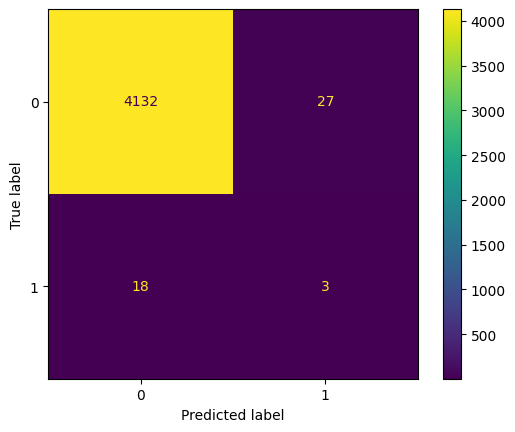

In [86]:
cm = confusion_matrix(y_true=df_test["is_pumped"], y_pred=y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

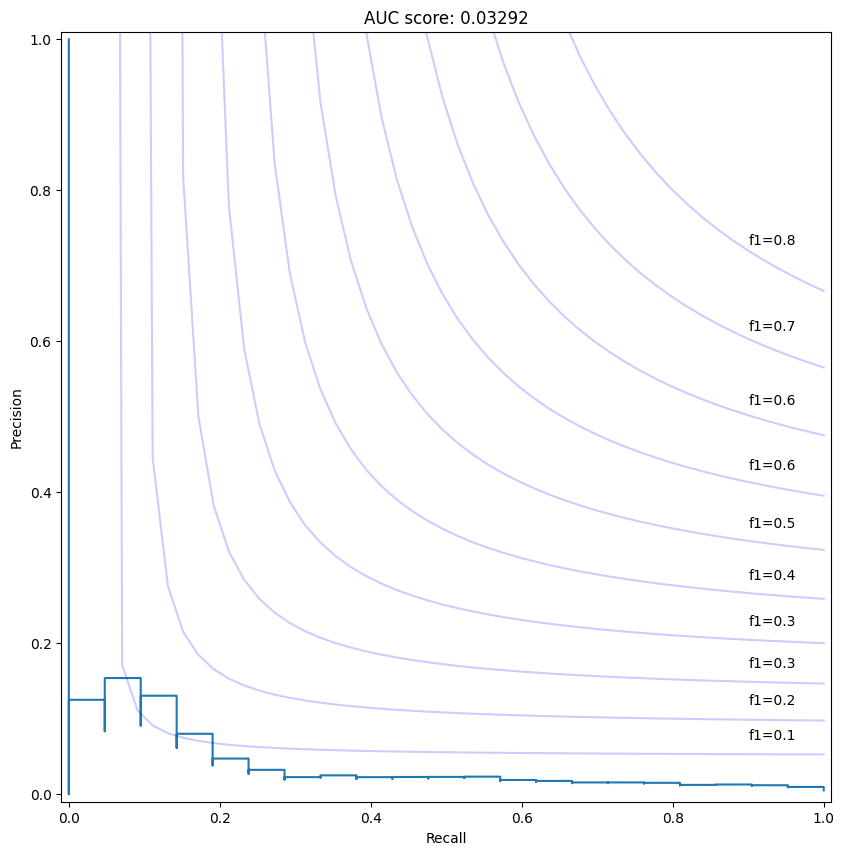

In [87]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_true=df_test["is_pumped"], probas_pred=y_proba)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

PrecisionRecallDisplay(
    precision=precision, recall=recall
).plot(ax=ax)

f_scores = np.linspace(0.1, 0.8, num=10)
lines, labels = [], []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
    ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.title(f"AUC score: {round(auc(recall, precision), 5)}")
plt.show()

In [88]:
# TOP-K metric
df_test["proba"] = y_proba

top_k_vals = []

for K in [1, 5, 10, 20, 40, 60]: 

    top_k: List[bool] = []

    for pump_hash, df_pump in df_test.groupby("pump_hash"):
        df_pump = df_pump.sort_values(by="proba", ascending=False)
        top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
        top_k.append(top_k_contains_pump)

    top_k_vals.append(
        sum(top_k) / len(top_k)
    )
        
top_k_vals

[0.047619047619047616,
 0.23809523809523808,
 0.2857142857142857,
 0.5238095238095238,
 0.6666666666666666,
 0.7619047619047619]

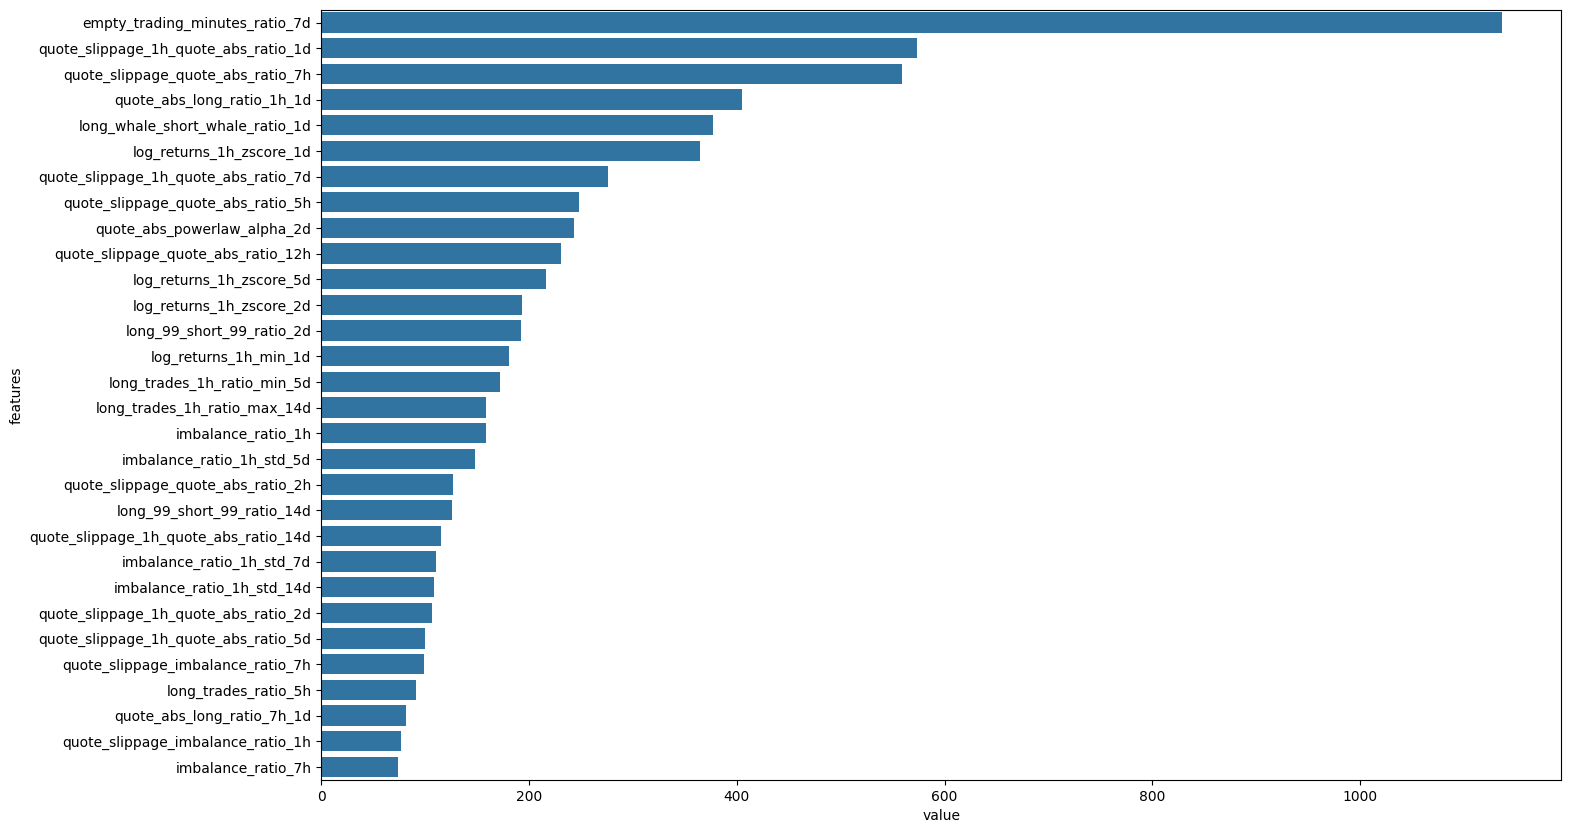

In [89]:
importances = model.get_score(importance_type="gain")

df_res = pd.DataFrame({
    "features": importances.keys(),
    "value": importances.values()
})

df_res = df_res.sort_values(by="value", ascending=False).iloc[:30]


fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111)

sns.barplot(
    data=df_res, x="value", y="features", ax=ax
)

plt.show()

In [90]:
from catboost import Pool, CatBoostClassifier


def catboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], target: str, fold: TimeSeriesSplit
) -> float:
    params = {
        "objective": "Logloss",
        "eval_metric": "Logloss",
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        "class_weights": [1, trial.suggest_float("scale_pos_weight", 1, 300)],
    }

    auc_scores = []
    
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df[target]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        train = Pool(data=df_train[reg_cols], label=df_train[target], cat_features=["num_prev_pumps"])
        val = Pool(data=df_val[reg_cols], label=df_val[target], cat_features=["num_prev_pumps"])
        
        # Fit the model with early stopping
        model = CatBoostClassifier(
            **params, 
            task_type="GPU",
            devices="0",
            iterations=500,
            early_stopping_rounds=20,
            verbose=False
        )

        model.fit(
            train, eval_set=val
        )
        
        y_proba = model.predict_proba(val)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        precision, recall, _ = precision_recall_curve(y_true=df_val["is_pumped"], probas_pred=y_proba)
        auc_score: float = auc(recall, precision)

        # _, f1_minority = f1_score(y_pred=y_pred, y_true=df_val[target], average=None)
        
        # get the best auc_score validation set
        auc_scores.append(auc_score)
        
        trial.report(auc_score, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        del model, train, val, y_pred
        _ = gc.collect()
        
        i += 1

    return np.mean(auc_scores)

In [100]:
study_catboost = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_catboost.optimize(
    partial(catboost_objective, df=df_train, reg_cols=num_cols, target="is_pumped", fold=fold), 
    n_trials=20
)

[I 2024-04-24 13:10:29,866] Trial 20 pruned. 
[I 2024-04-24 13:10:32,063] Trial 21 pruned. 
[I 2024-04-24 13:10:36,774] Trial 22 pruned. 
[I 2024-04-24 13:10:50,771] Trial 23 pruned. 
[I 2024-04-24 13:10:52,228] Trial 24 pruned. 
[I 2024-04-24 13:11:12,423] Trial 25 finished with value: 0.10098742993683626 and parameters: {'learning_rate': 0.06029886594498658, 'max_depth': 9, 'scale_pos_weight': 34.87105779253686}. Best is trial 2 with value: 0.1335449297460181.
[I 2024-04-24 13:11:18,492] Trial 26 finished with value: 0.12099451524164143 and parameters: {'learning_rate': 0.032975336146744576, 'max_depth': 4, 'scale_pos_weight': 70.5356063529469}. Best is trial 2 with value: 0.1335449297460181.
[I 2024-04-24 13:11:21,673] Trial 27 pruned. 
[I 2024-04-24 13:11:22,941] Trial 28 pruned. 
[I 2024-04-24 13:11:23,929] Trial 29 pruned. 
[I 2024-04-24 13:11:40,398] Trial 30 finished with value: 0.1505063816103012 and parameters: {'learning_rate': 0.036849778634946255, 'max_depth': 2, 'scale_po

In [101]:
train = Pool(data=df_train[num_cols], label=df_train["is_pumped"])
test = Pool(data=df_test[num_cols], label=df_test["is_pumped"])

In [102]:
cb_params = {
    "objective": "Logloss",
    "task_type": "GPU"
}

cb_params.update(study_catboost.best_params)
cb_params["class_weights"] = [1, study_catboost.best_params["scale_pos_weight"]]

del cb_params["scale_pos_weight"]

model = CatBoostClassifier(**cb_params, iterations=300)
model.fit(train)

0:	learn: 0.6696708	total: 5.01ms	remaining: 1.5s
1:	learn: 0.6483742	total: 7.86ms	remaining: 1.17s
2:	learn: 0.6266527	total: 11.1ms	remaining: 1.1s
3:	learn: 0.6075257	total: 13.1ms	remaining: 971ms
4:	learn: 0.5905006	total: 15.5ms	remaining: 914ms
5:	learn: 0.5738615	total: 18.9ms	remaining: 925ms
6:	learn: 0.5591114	total: 21.8ms	remaining: 913ms
7:	learn: 0.5454883	total: 24.6ms	remaining: 899ms
8:	learn: 0.5224512	total: 26.7ms	remaining: 862ms
9:	learn: 0.5115227	total: 28.6ms	remaining: 829ms
10:	learn: 0.5011981	total: 30.6ms	remaining: 805ms
11:	learn: 0.4916980	total: 32.6ms	remaining: 782ms
12:	learn: 0.4817311	total: 34.5ms	remaining: 762ms
13:	learn: 0.4728256	total: 36.3ms	remaining: 742ms
14:	learn: 0.4649744	total: 38.6ms	remaining: 733ms
15:	learn: 0.4563089	total: 40.5ms	remaining: 719ms
16:	learn: 0.4497618	total: 42.4ms	remaining: 706ms
17:	learn: 0.4423371	total: 44.9ms	remaining: 703ms
18:	learn: 0.4365624	total: 47ms	remaining: 695ms
19:	learn: 0.4301254	total

In [109]:
y_proba = model.predict_proba(test)
y_pred = y_proba[:, 1] >= 0.3

In [110]:
print(classification_report(y_true=df_test["is_pumped"], y_pred=y_pred))

              precision    recall  f1-score   support

       False       1.00      0.98      0.99      4159
        True       0.10      0.52      0.16        21

    accuracy                           0.97      4180
   macro avg       0.55      0.75      0.58      4180
weighted avg       0.99      0.97      0.98      4180



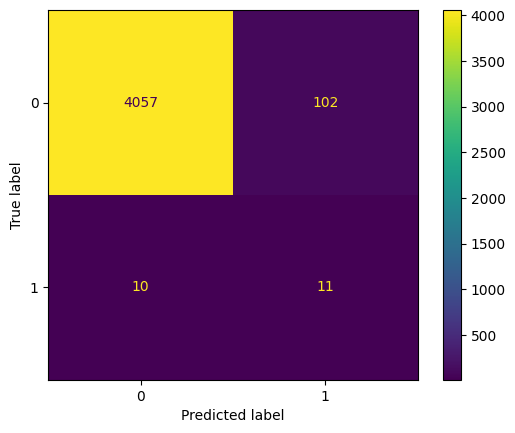

In [111]:
cm = confusion_matrix(y_true=df_test["is_pumped"], y_pred=y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

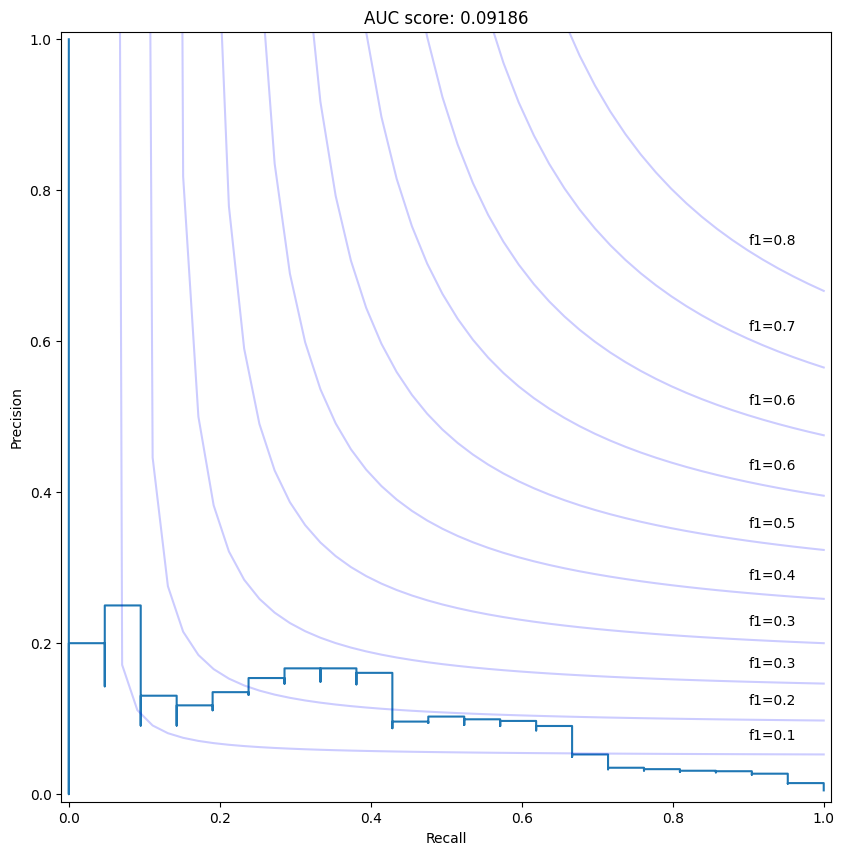

In [112]:
precision, recall, thresholds = precision_recall_curve(y_true=df_test["is_pumped"], probas_pred=y_proba[:, 1])

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

PrecisionRecallDisplay(
    precision=precision, recall=recall
).plot(ax=ax)

f_scores = np.linspace(0.1, 0.8, num=10)
lines, labels = [], []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
    ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.title(f"AUC score: {round(auc(recall, precision), 5)}")
plt.show()

In [113]:
# TOP-K metric
df_test["proba"] = y_proba[:, 1]

top_k_vals = []

for K in [1, 5, 10, 20, 40, 60]: 

    top_k: List[bool] = []

    for pump_hash, df_pump in df_test.groupby("pump_hash"):
        df_pump = df_pump.sort_values(by="proba", ascending=False)
        top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
        top_k.append(top_k_contains_pump)

    top_k_vals.append(
        sum(top_k) / len(top_k)
    )

top_k_vals       

[0.09523809523809523,
 0.5238095238095238,
 0.6190476190476191,
 0.7142857142857143,
 0.9523809523809523,
 1.0]

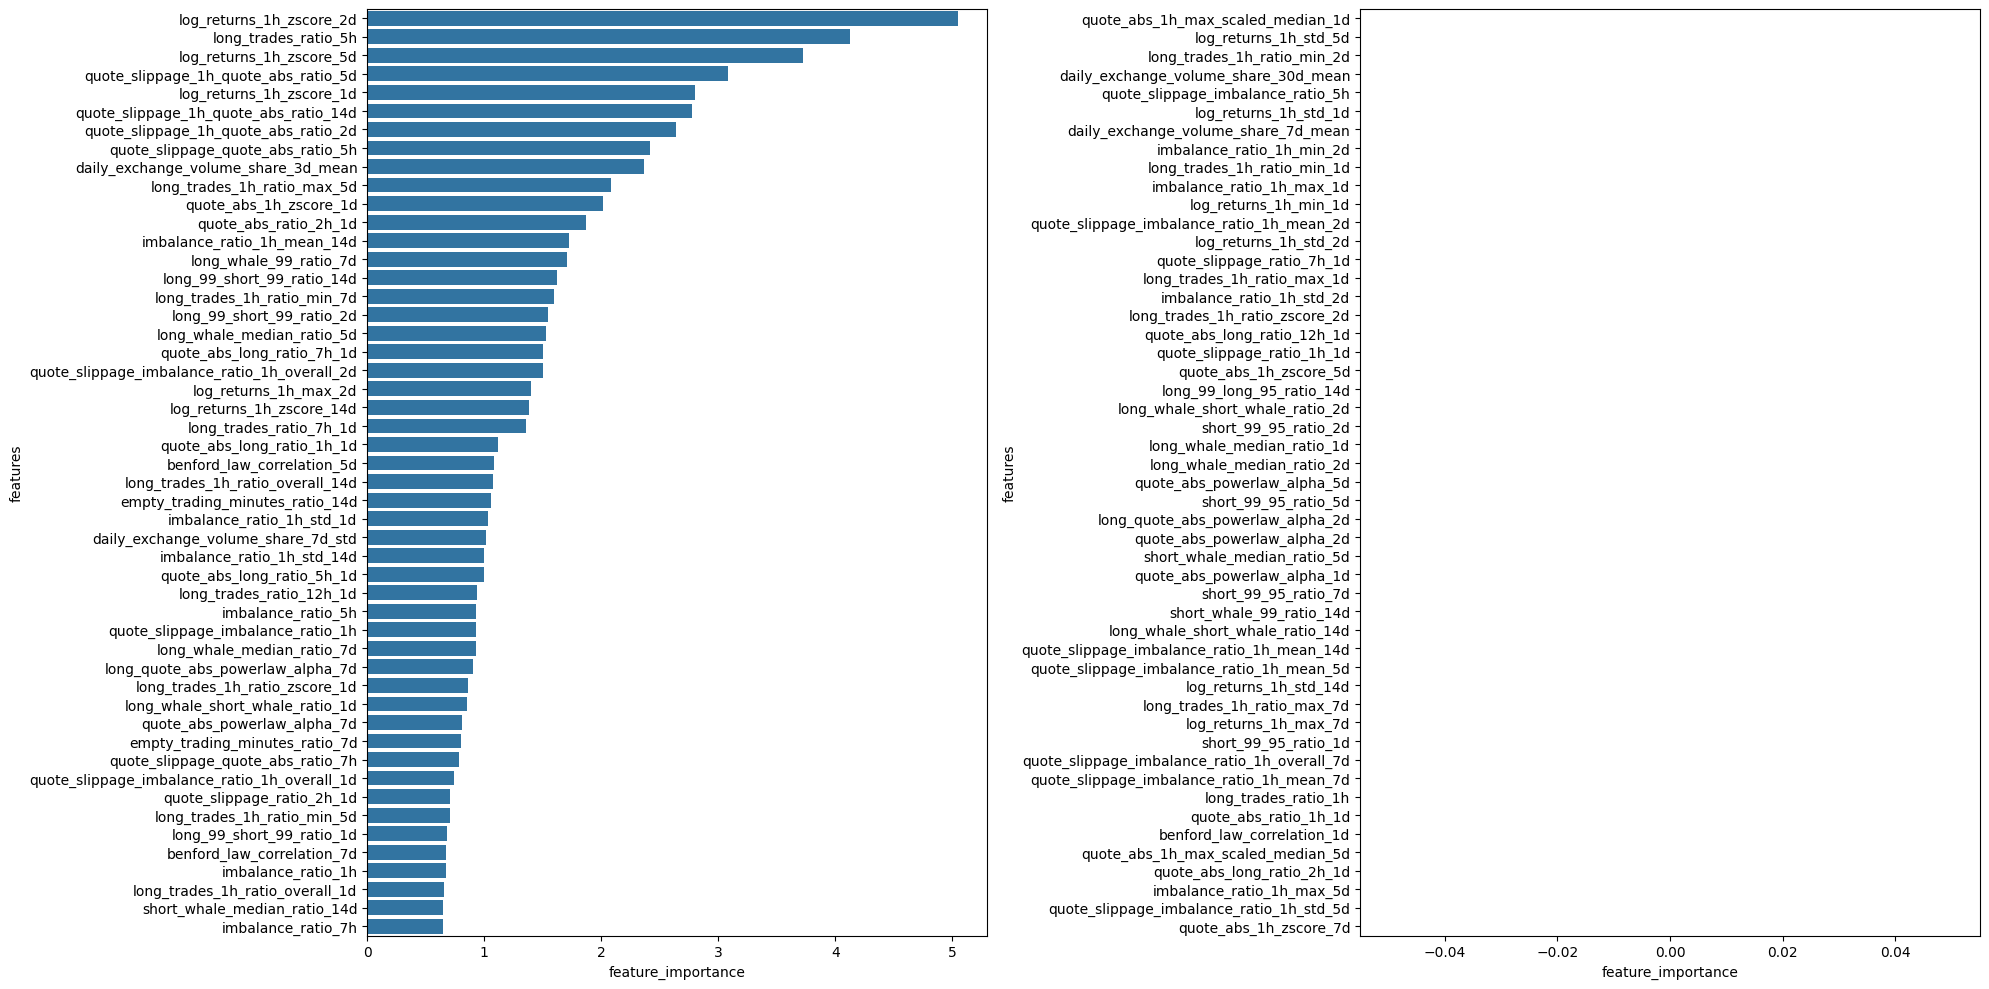

In [99]:
df_fi = pd.DataFrame({
    "features": num_cols,
    "feature_importance": model.feature_importances_
})

df_fi = df_fi.sort_values(by="feature_importance", ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axs

sns.barplot(
    data=df_fi.iloc[:50], x="feature_importance", y="features", ax=ax1
)
sns.barplot(
    data=df_fi.iloc[-50:], x="feature_importance", y="features", ax=ax2
)

plt.tight_layout()
plt.show()